In [2]:
#%matplotlib
import numpy as np
pi = np.pi
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *
from qip.kpoprocessor import KPOProcessor
import scipy.io as spio
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%load_ext autoreload
%autoreload 2


# Figures should have a width of a 8.6 cm or 3 3/8 in, the width of a single manuscript column.
golden_mean = (np.sqrt(5)-1.0)/2.0 # Aesthetic ratio
fig_width = 3+3/8 # width in inches
fig_height = fig_width*golden_mean # height in inches (0.75 is the standard height to width ratio in Python)
fig_size = [fig_width, fig_height]
mpl.rcParams.update({
    'axes.labelsize' : 12,
    'font.size' : 12,
    'legend.fontsize' : 8,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'ytick.minor.pad' : -0.5,
    'ytick.minor.pad' : -0.5,
    'ytick.major.size' : 2,
    'ytick.minor.size' : 2,
    'ytick.major.width' : .5,
    'ytick.minor.width' : .5,
    'xtick.major.size' : 2,
    'xtick.minor.size' : 2,
    'xtick.major.width' : .5,
    'xtick.minor.width' : .5,
    'xtick.major.pad' : 1.5,
    'xtick.minor.pad' : 1.5,
    'text.usetex' : True,
    'figure.dpi' : 100,
})


<a href="#Ry">Ry</a>

In [3]:
# Problem
J = -1*np.array([[1,1/2],[1/2,1/2]])
h = -1*np.array([1/2,0])

# Eigvals [2 1 0 1]

# Number of qubits in the system
N = 2

In [3]:
name = 'instance_5_1_simple'
mat = spio.loadmat('../../Matlab/matqaoa/jeppesen_instances_simple/' + name + '.mat')
instance = mat['instance']
eigvals = instance['eigvals']
N = instance['size'][0][0][0][0]
J = instance['J'][0][0]
h = np.array(instance['h'][0][0]).flatten()
costs = np.array(eigvals[0][0]).flatten()

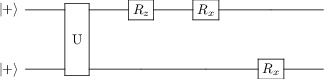

In [127]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

# Iteration level
p = 1

if p == 1:
    # Angles p = 1
    gamma = [0.9046]
    beta = [2.6893]
    # 100 %
    gamma = [np.pi]
    beta = [2.3562]
elif p == 2:    
    # Angles p = 2
    gamma = [pi/2, pi/2]
    beta = [2.3562, 2.3562]

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)
qc.user_gates = {"CARB": carb}
qc.add_state(state = "+", targets = range(N), state_type = "input")

for i in range(p):
    for j in range(N-1):
        for k in range(j+1,N):
            if J[j][k] != 0:
                qc.add_gate("CARB", targets = [j,k], arg_value = 2*gamma[i]*J[j][k])
    for j in range(N):
        if h[j] != 0: 
            qc.add_gate("RZ", j, None, 2*gamma[i]*h[j])
        if 2*beta[i] > np.pi:
            qc.add_gate("RX", j, None, 2*np.pi - 2*beta[i])
            #qc.add_gate("RZ", j, None, 2*np.pi)

qc.png

In [128]:
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
print("Total time = %s (1/K)" % round(tlist[-1]))

Total time = 14.0 (1/K)


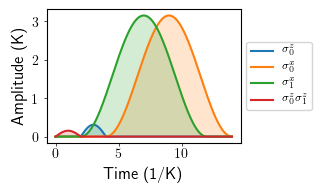

In [129]:
fig = kpo.plot_pulses(figsize=fig_size)
#plt.savefig('figs/fig-qaoa-level-2-pulses-rx-mixer.pdf', dpi=300, transparent=False, bbox_inches='tight')

## Setup parameters and initial values

In [135]:
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl)

# Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

# initial state
plus = (cat_plus + 1j*cat_minus)/np.sqrt(2)
psi0 = tensor([plus for i in range(N)])

## Run master equation

In [ ]:
# simulate
result = kpo.run_state(init_state = psi0, noisy = True)
final_state = result.states[-1]

In [137]:
final_state
#qsave(final_state,'results/noisy-qaoa-level-2-rx-mixer')

Quantum object: dims = [[20, 20], [1, 1]], shape = (400, 1), type = ket
Qobj data =
[[ 1.76145926e-02+1.66714485e-03j]
 [ 3.60994950e-02+4.30081313e-03j]
 [ 5.02353294e-02+5.50658282e-03j]
 [ 5.89076140e-02+7.32784401e-03j]
 [ 5.81581812e-02+6.49677417e-03j]
 [ 5.27085859e-02+6.66929828e-03j]
 [ 4.25297851e-02+4.77725429e-03j]
 [ 3.25462881e-02+4.15446499e-03j]
 [ 2.27516770e-02+2.56181084e-03j]
 [ 1.53467158e-02+1.96957306e-03j]
 [ 9.59819186e-03+1.08106335e-03j]
 [ 5.85532242e-03+7.53372854e-04j]
 [ 3.34344295e-03+3.76601233e-04j]
 [ 1.87601831e-03+2.42941785e-04j]
 [ 9.91540686e-04+1.11959996e-04j]
 [ 5.16908007e-04+6.70538005e-05j]
 [ 2.55042347e-04+2.91733781e-05j]
 [ 1.25367795e-04+1.56910849e-05j]
 [ 5.53036545e-05+6.42076323e-06j]
 [ 2.60024241e-05+3.06378070e-06j]
 [-3.64755419e-02-4.47335807e-03j]
 [-7.31452887e-02-9.03943837e-03j]
 [-1.02393192e-01-1.30111731e-02j]
 [-1.19015152e-01-1.45660910e-02j]
 [-1.18047039e-01-1.51649551e-02j]
 [-1.06250296e-01-1.28998364e-02j]
 [-8.6

## Calculate success probability

In [138]:
target_state = tensor(down,up)
if final_state.type == 'ket':
    f = (target_state.dag() * final_state).full()[0][0]
    f = abs(f)**2
else:
    f = abs((target_state.dag() * final_state * target_state).full()[0][0])
print("Success Probability = %s %%" % round(f*100,3))

Success Probability = 99.997 %


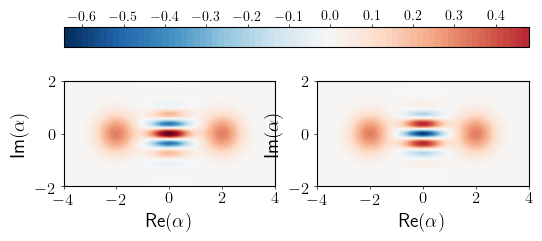

In [133]:
q0 = final_state.ptrace(0)
q1 = final_state.ptrace(1)
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
W0 = wigner(q0,xvec,yvec,'iterative',2)
W1 = wigner(q1,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W0.max(), W0.max()) # Normalize colors

# contour plot
plt.subplot(121,aspect='equal')
im = plt.contourf(xvec, yvec, W0, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# contour plot
plt.subplot(122,aspect='equal')
im = plt.contourf(xvec, yvec, W1, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.72, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W0.min())-1,round(W0.max()+.1)+.1,0.1));

## <a name="Ry">QAOA but with a $R_y$-gate</a>

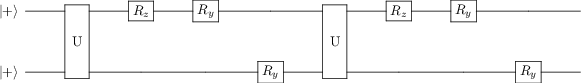

In [116]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

# Iteration level
p = 2

if p == 1:
    # Angles p = 1 100% success
    #gamma = [np.pi]
    #beta = [0.7823]
    # angles p = 1 50% success
    gamma = [0.8999]
    beta = [2.6838]
    gamma = [0.9046]
    beta = [2.6893]
elif p == 2:    
    # Angles p = 2
    # Angles p = 2
    gamma = [pi/2, pi/2]
    beta = [2.3562, 2.3562]

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)
qc.user_gates = {"CARB": carb}
qc.add_state(state = "+", targets = range(N), state_type = "input")

for i in range(p):
    for j in range(N-1):
        for k in range(j+1,N):
            if J[j][k] != 0:
                qc.add_gate("CARB", targets = [j,k], arg_value = 2*gamma[i]*J[j][k])
    for j in range(N):
        if h[j] != 0: 
            qc.add_gate("RZ", j, None, 2*gamma[i]*h[j])
        qc.add_gate("RY", j, None, 2*beta[i])

qc.png

In [117]:
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
print("Total time = %s (1/K)" % round(tlist[-1]))

Total time = 18.0 (1/K)


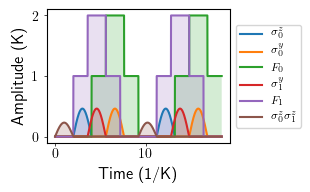

In [118]:
fig = kpo.plot_pulses(figsize=fig_size)
#plt.savefig('figs/fig-qaoa-pulses-ry-mixer.pdf', dpi=300, transparent=False, bbox_inches='tight')

## Setup parameters and initial values

In [119]:
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl)

# computational basis
up = coherent(num_lvl, alpha) # logical zero
down = coherent(num_lvl,-alpha) # logical one

# initial state
plus = (up-1j*down).unit()
psi0 = tensor([plus for i in range(N)])

## Run master equation

In [123]:
# simulate
result = kpo.run_state(init_state = psi0, noisy = True)
final_state = result.states[-1]

In [125]:
qsave(final_state, 'results/noisy-qaoa-level-2-ry-mixer')

## Calculate success probability

In [126]:
target_state = tensor(down,up)
if final_state.type == 'ket':
    f = (target_state.dag() * final_state).full()[0][0]
    f = abs(f)**2
else:
    f = abs((target_state.dag() * final_state * target_state).full()[0][0])
print("Success Probability = %s %%" % round(f*100,3))

Success Probability = 91.357 %


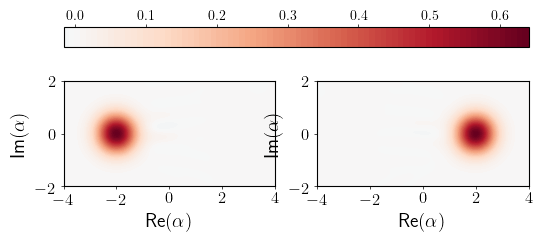

In [115]:
q0 = final_state.ptrace(0)
q1 = final_state.ptrace(1)
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
W0 = wigner(q0,xvec,yvec,'iterative',2)
W1 = wigner(q1,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W0.max(), W0.max()) # Normalize colors

# contour plot
plt.subplot(121,aspect='equal')
im = plt.contourf(xvec, yvec, W0, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# contour plot
plt.subplot(122,aspect='equal')
im = plt.contourf(xvec, yvec, W1, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.72, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W0.min())-1,round(W0.max()+.1)+.1,0.1));

In [2]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

N = 2

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)
qc.user_gates = {"CARB": carb}
qc.add_state(state = "+", targets = range(N), state_type = "input")

qc.add_gate("CARB", targets = [0,1], arg_value = 2)

In [4]:
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
print("Total time = %s (1/K)" % round(tlist[-1]))

AttributeError: 'KPOCompiler' object has no attribute 'dt_list'